Found 225 images belonging to 15 classes.
Found 90 images belonging to 15 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Test loss: 0.8090696334838867
Test accuracy: 0.8333333134651184
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
         

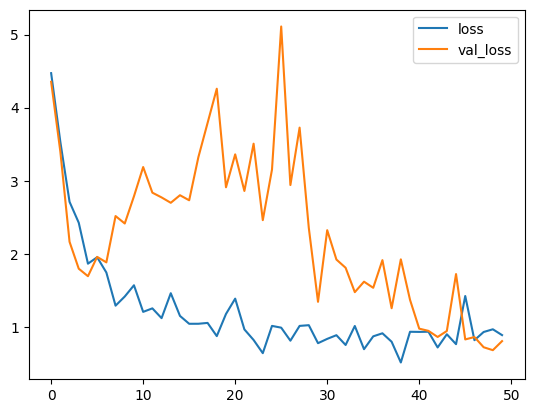

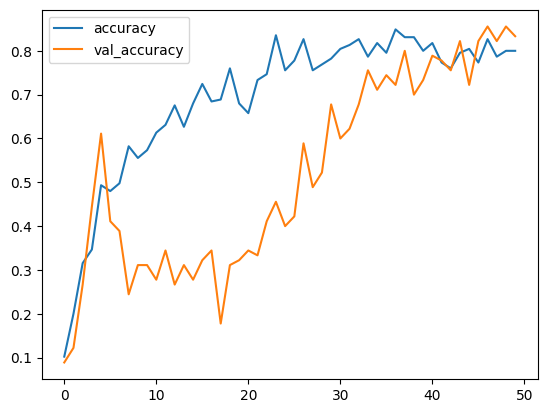

In [8]:
# 画像の読み込み
# $bash copy_image.sh　実行後のディレクトリ構成
# ref: https://qiita.com/ba--shi/items/09f5f2f119ffbd9bb316
import os
import cv2 # dockerの場合　$apt install libgl1-mesa-dev
import matplotlib.pyplot as plt
import tensorflow as tf

def modify_image(img, width, height):
    """指定した大きさに収まるように、アスペクト比を固定して、リサイズする。
       ref: https://camp.trainocate.co.jp/magazine/python-opencv/
    """
    h, w = img.shape[:2]
    aspect = w / h
    if width / height >= aspect:
        nh = height
        nw = round(nh * aspect)
    else:
        nw = width
        nh = round(nw / aspect)

    scaled = cv2.resize(img, dsize=(nw, nh))
    h_padding = round((height - nh) / 2)
    w_padding = round((width - nw) / 2)
    dst = cv2.copyMakeBorder(scaled, h_padding, height - nh - h_padding, w_padding, width- nw - w_padding, cv2.BORDER_REPLICATE)

    return dst

def read_image():
    image_list = []
    label_list = []
    
    BASE_DIR = os.getcwd()

    for dir in os.listdir(BASE_DIR + "/images"):
        img_dir =  BASE_DIR + "/images/" + dir
        # フォルダごとにラベル分けする
        label = dir

        for file in os.listdir(img_dir):
            # 配列label_listに正解ラベルを追加
            label_list.append(label)

            # 配列image_listに画像の配列データを追加
            filepath = img_dir + "/" + file
            image = cv2.imread(filepath)
            image = modify_image(image, IMAGE_SIZE, IMAGE_SIZE)
            # cv2.imwrite(f'modifyed/{file}', image)
            # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # plt.show()
            # image = img_to_array(img)
            # img_r = tf.io.read_file(filepath)
            # image = tf.image.decode_jpeg(img_r, channels=3)
            image_list.append(image)
    
    return image_list, label_list



import tensorflow as tf
import numpy as np

# X = np.asarray(image_list).astype('float32') / 255.0

# Y = np.asarray(label_list)
# Y = tf.keras.utils.to_categorical(Y, N_CLASSES)

# print(X.shape, Y.shape)

# from sklearn.model_selection import train_test_split

# train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

N_CLASSES = 15
IMAGE_SIZE = 500
BATCH_SIZE = 32

# data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     # rescale=1./255,
#     zoom_range=0.2,
#     rotation_range=45,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     channel_shift_range=0.1,
# )
# train_generator = data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE, target shuffle=True)
train_data_augmer = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    zoom_range=0.2,
    rotation_range=45,
    height_shift_range=0.2,
    width_shift_range=0.2,
    # channel_shift_range=0.1,
    brightness_range=[0.8,1.1],
)
valid_data_augmer = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_data_augmer.flow_from_directory(
    directory="compe/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
valid_generator = valid_data_augmer.flow_from_directory(
    directory="compe/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
def show_imgs(imgs, row, col):
    for i, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.tick_params(labelbottom=False)
        plt.tick_params(labelleft=False)
        plt.imshow(img)
    plt.show()

# for i in range(3):
#     data = next(train_generator)
#     show_imgs(data[0], 4, 4)

def step_decay(epoch):
    lr = 0.001
    if(epoch >= 100):
        lr/=5
    if(epoch>=140):
        lr/=2
    return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'data/temp/road_sign_sequential_{epoch:03d}_{val_loss:.4f}.h5',
        save_best_only=True
    ),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir='logs',
    #     histogram_freq=1
    # ),
    step_decay,
]



from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Input, BatchNormalization, Resizing, Rescaling
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg_model.layers:
    layer.trainable = False

# inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = vgg_model.output
x = BatchNormalization()(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
x = GrobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

EPOCHS = 150

model = tf.keras.Model(inputs=vgg_model.input, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=valid_generator, callbacks=callbacks)
# history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
model.save('model.keras')



score = model.evaluate(valid_generator, verbose='0')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# !tensorboard --logdir logs/fit



import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot()
hist_df[['accuracy', 'val_accuracy']].plot()

print(model.summary())





In [9]:
# X = np.asarray(image_list).astype('float32') / 255.0

# N_CLASSES = 15
# Y = np.asarray(label_list)
# Y = tf.keras.utils.to_categorical(Y, N_CLASSES)


test_data_augmer = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

test_generator = test_data_augmer.flow_from_directory(
    directory="Test_images",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
score = model.evaluate(test_generator, verbose='1')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 403 images belonging to 15 classes.
Test loss: 1.9560587406158447
Test accuracy: 0.5260545611381531


0.5024752616882324
0.5668317079544067
0.5891088843345642